In [1]:
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py

import processor
import xgb_model
import utils

In [2]:
data_dir = "/Users/shashankmanjunath/Documents/nfl_bdb_2025/data/"
test_weeks = [8, 9]
proc = processor.SeparationDataProcessor(data_dir)

In [3]:
with open("xgb_model_all.pkl", "rb") as f:
    bst = pickle.load(f)

In [4]:
cache_fname = proc.cache_file_fname
with h5py.File(cache_fname, "r") as all_weeks_f:
    X = []
    y = []
    play_ids = []
    for week_num in test_weeks:
        f = all_weeks_f[f"week_{week_num}"]
        n = f["seq_arr"].shape[0]
        for idx in tqdm(range(n)):
            y.append(f["separation_arr"][idx])
            play_players_df = pd.DataFrame(
                f["play_players_arr"][idx, :, :],
                columns=xgb_model.decode(f["play_players_cols"]),
            )
            play_players_df["nflId"] = play_players_df["nflId"].astype(int)
            play_overall_df = pd.DataFrame(
                f["play_overall_arr"][idx, :, :],
                columns=xgb_model.decode(f["play_overall_cols"]),
            )
            play_overall_df["nflId"] = play_overall_df["nflId"].astype(int)
            meta_df = pd.DataFrame(
                f["meta_arr"][idx, :].reshape(1, -1),
                columns=xgb_model.decode(f["meta_cols"]),
            )
            play_ids.append(play_overall_df[["gameId", "playId"]].iloc[0].astype(int))
            
            pos_cols = xgb_model.get_position_cols()
        
            seq_mask = f["seq_mask"][idx, :, 0, 0].astype(int)
            idxs = np.where(seq_mask)[0]
            seq_len = idxs.max() + 1
            pos_arr = f["seq_arr"][idx, :seq_len, :, :]
            pos_df = []
            for seq_idx in range(pos_arr.shape[0]):
                seq_df = pd.DataFrame(pos_arr[seq_idx, :, :], columns=xgb_model.decode(f["seq_cols"]))
                seq_df = seq_df.drop(seq_df[seq_df["club_football"] == 1.0].index)
                seq_df["nflId"] = seq_df["nflId"].astype(int)
                
                seq_df = seq_df.merge(play_players_df, how="outer", on="nflId")
                seq_df = seq_df.merge(play_overall_df, how="outer", on=["gameId", "playId", "nflId"])
                
                seq_df["position_ord"] = np.argmax(seq_df[pos_cols].to_numpy(), axis=1)
                seq_df = seq_df.sort_values(by="position_ord")
                seq_df = seq_df[seq_df["wasTargettedReceiver"] == 1.0]
                seq_df = seq_df.merge(meta_df, how="outer", on=["gameId", "playId"])

                pos_df.append(seq_df)
            X.append(pd.concat(pos_df, axis=0))

play_ids = pd.concat(play_ids, axis=1).T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [02:57<00:00,  3.97it/s]


In [58]:
in_motion_arr = [x["inMotionAtBallSnap"].sum() > 0 for x in X]
shift_arr = [x["shiftSinceLineset"].sum() > 0 for x in X]
motion_arr = [x["motionSinceLineset"].sum() > 0 for x in X]

play_ids["inMotionAtBallSnap"] = in_motion_arr
play_ids["shiftSinceLineset"] = shift_arr
play_ids["motionSinceLineset"] = motion_arr

in_motion_idxs = np.where(in_motion_arr)
shift_idxs = np.where(shift_arr)
motion_idxs = np.where(motion_arr)

In [59]:
pred_arr = []
for idx in tqdm(range(len(X))):
    y_true = y[idx]
    seq_df = X[idx][utils.get_target_feature_cols()]
    pred_sep = bst.predict(seq_df)
    pred_arr.append(pred_sep)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1494/1494 [00:10<00:00, 146.91it/s]


True Final Separation: 0.23706539182258815


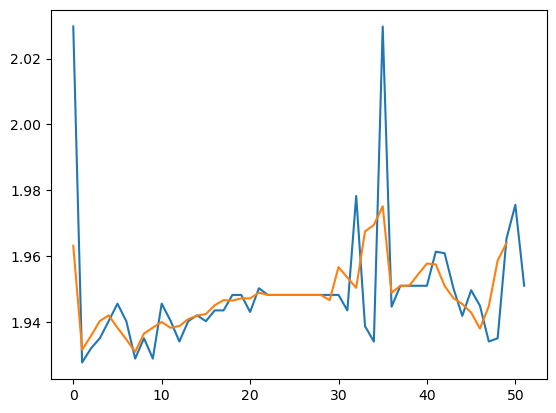

In [60]:
idx = 24

print(f"True Final Separation: {y[idx]}")
pred_lp = np.convolve(pred_arr[idx], np.ones(3)/3, mode='valid')

plt.figure()
plt.plot(pred_arr[idx])
plt.plot(pred_lp)
plt.show()

In [61]:
def ste(sep_arr):
    if len(pred_sep) < 5:
        return -1        
        
    n_steps = 3
    pred_lp = np.convolve(pred_sep, np.ones(n_steps)/n_steps, mode='valid')

    t_max = np.argmax(pred_lp)
    s_max = pred_lp[t_max]

    t_snap = len(pred_lp) - 1
    s_snap = pred_lp[-1]

    ste_val = (s_snap / s_max) * ((t_max + 1) / (t_snap + 1))

    return ste_val

In [62]:
ste_arr = []

for idx, pred_sep in enumerate(pred_arr):
    if len(pred_sep) < 5:
        ste_arr.append(np.nan)
        continue

    ste_arr.append(ste(pred_sep))

In [83]:
play_ids = play_ids.reset_index(drop=True)
play_ids["ste"] = ste_arr
play_ids["pred_sep"] = pred_arr

data = utils.load_data(data_dir)
play_data = data["play"]

ste_data = play_data.merge(play_ids, on=["gameId", "playId"])

Loading data from disk.... Data Loaded! Load time: 0.603 seconds


(11:07) (Shotgun) M.Stafford pass short right to B.Powell pushed ob at LA 23 for 4 yards (K.Neal).


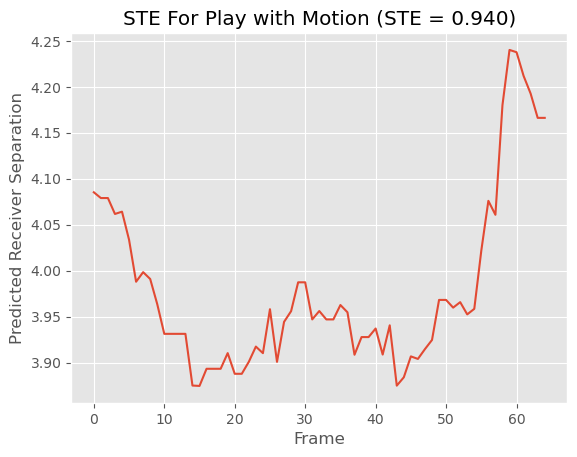

In [96]:
motion_loc = 66
mrow = ste_data.loc[motion_loc]
ste_val = mrow["ste"]
print(mrow["playDescription"])

plt.style.use("ggplot")
plt.figure()
plt.plot(mrow["pred_sep"])
plt.title(f"STE For Play with Motion (STE = {ste_val:.3f})")
plt.xlabel("Frame")
plt.ylabel("Predicted Receiver Separation")
plt.savefig("imgs/motion_ste_good.png", dpi=400)
plt.show()

(:34) (Shotgun) M.Mariota pass short middle to K.Pitts to ATL 38 for 10 yards (D.Jackson, J.Burris).


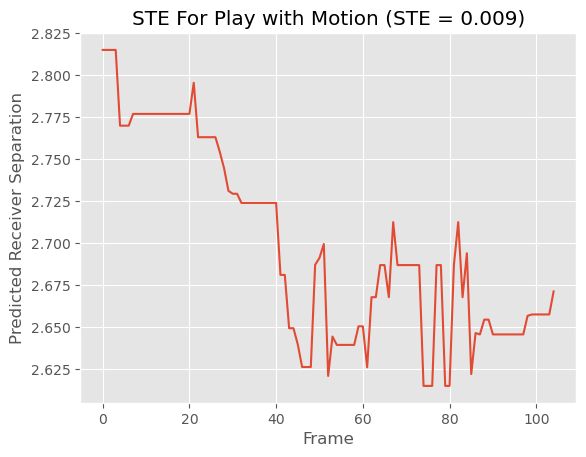

In [97]:
motion_loc = 205
mrow = ste_data.loc[motion_loc]
ste_val = mrow["ste"]
print(mrow["playDescription"])

plt.style.use("ggplot")
plt.figure()
plt.plot(mrow["pred_sep"])
plt.title(f"STE For Play with Motion (STE = {ste_val:.3f})")
plt.xlabel("Frame")
plt.ylabel("Predicted Receiver Separation")
plt.savefig("imgs/motion_ste_bad.png", dpi=400)
plt.show()

In [98]:
ste_data

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,ste,pred_sep,inMotionAtBallSnap,shiftSinceLineset,motionSinceLineset
0,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,NaN,NaN,0,Quarters,Zone,0.887985,"[3.8886104, 3.9131627, 3.8886104, 3.8886104, 3...",False,False,False
1,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,NaN,NaN,0,Quarters,Zone,0.880357,"[3.83006, 3.8312569, 3.8312569, 3.8773754, 3.8...",False,False,False
2,2022110603,2325,"(7:36) (No Huddle, Shotgun) A.Rodgers pass sho...",3,2,9,GB,DET,GB,47,...,NaN,NaN,0,Quarters,Zone,0.460741,"[2.2847745, 2.2847745, 2.2847745, 2.2847745, 2...",False,False,False
3,2022110607,3178,(9:59) (Shotgun) T.Heinicke pass short left to...,4,2,7,WAS,MIN,WAS,28,...,NaN,NaN,0,Quarters,Zone,0.833052,"[3.9221933, 3.9640212, 3.9374022, 3.9250314, 3...",False,False,False
4,2022103001,664,(3:15) (Shotgun) M.Mariota pass short left to ...,1,2,6,ATL,CAR,ATL,42,...,MAN,NaN,1,Cover-3,Zone,0.789488,"[3.8088768, 3.8088768, 3.8311138, 3.8311138, 3...",False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,2022110610,2875,(2:19) (Shotgun) P.Mahomes pass short left to ...,3,1,10,KC,TEN,TEN,46,...,NaN,NaN,0,Quarters,Zone,0.693542,"[3.841345, 3.868462, 3.8244824, 3.8244824, 3.8...",True,False,True
1490,2022103006,557,(6:20) (Shotgun) A.Dalton pass short left to A...,1,1,10,NO,LV,NO,31,...,NaN,NaN,0,Cover-0,Man,0.010940,"[2.5349789, 2.5349789, 2.5315497, 2.5315497, 2...",False,False,True
1491,2022110605,982,(11:50) M.Jones pass short right to H.Henry to...,2,1,10,NE,IND,IND,43,...,NaN,NaN,0,Cover-2,Zone,1.000000,"[3.0485153, 3.0485153, 3.021185, 3.0137074, 3....",False,False,False
1492,2022110600,1138,(8:12) (Shotgun) J.Herbert pass short right to...,2,2,15,LAC,ATL,ATL,41,...,NaN,NaN,0,Cover-2,Zone,0.027651,"[3.5196264, 3.4755526, 3.489342, 3.4895856, 3....",False,False,False


gameId    2022103001
playId          3953
Name: 0, dtype: int64
Minimum STE: 1.0
Index: 3953


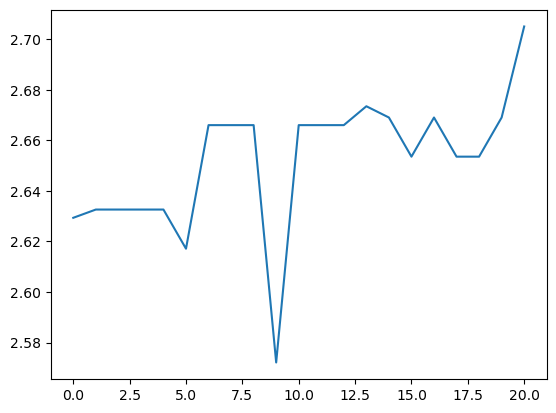

In [12]:
min_idx = np.argmax(ste_arr)
print(play_ids.iloc[min_idx])
print(f"Minimum STE: {ste_arr[min_idx]}")
print(f"Index: {play_ids.iloc[min_idx]['playId']}")
plt.figure()
plt.plot(pred_arr[min_idx])
plt.show()

In [ ]:
with h5py.File(cache_fname, "r") as all_weeks_f:
    for week_num in test_weeks:
        f = all_weeks_f[f"week_{week_num}"]
        meta_df = pd.DataFrame(
            f["meta_arr"],
            columns=xgb_model.decode(f["meta_cols"]),
        )

In [ ]:
data = utils.load_data(data_dir)
play_data = data["play"]

In [ ]:
play_data[(play_data["gameId"] == 2022110608)]

In [ ]:
play_ids.iloc[0]["gameId"].astype(int).item()

In [ ]:
play_ids.iloc[0].astype(int)["gameId"].item()

In [ ]:
play_ids.iloc[0]["gameId"]

In [ ]:
play_data["gameId"]

In [ ]:
pd.concat([x.iloc[0].astype(int) for x in play_ids], axis=1).T

In [ ]:
(play_data["gameId"] == 2022091111).sum()

In [ ]:
max_ste = np.argmax(ste_arr)
plt.figure()
plt.plot(pred_arr[max_ste])
plt.show()